## DS7731 - Tenure Prediction with SVM 
Team: Amber, Jeremy, Lance, Shawn 

In [1]:
# load required libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline 

from sklearn.svm import SVC #load the SVM-related library
# load model selection/metric related library 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# we will try Pipelining if we have more time 
from sklearn.pipeline import Pipeline 



In [2]:
# import the telco churn data as dataframe named 'df'
url = 'https://raw.githubusercontent.com/jotsap/DS7331/master/data/churn.csv'
df = pd.read_csv(url)

In [3]:
# Let's check if it is loaded ok 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We are building a classifier that can predict if a customer will continue the tenure at least 12 months. In this context, we will create a new response variable [OneYearYN] based on the condiction below\ 
* OneYearYN == 1 when the 'tenure' period is equal or larger than 12 regardless of 'Churn' 
* OneYearYN == 0 when the 'tenure' period is less than 12 and 'Churn' is 'Yes' 
* If the 'tenure' period is less than 12 and 'Churn' is 'No', we will remove such observations from the fitting. Such records are not aligned with the business problem we are going to solve, since we cannot determine 12-month period churn for them 

In [4]:
df['OneYearYN'] = 2 #such records will be dropped later, as discussed above 

In [5]:
df.loc[(df['tenure'] >=  12), 'OneYearYN'] = 1
df.loc[(df['tenure'] < 12) & (df['Churn'] == 'Yes'), 'OneYearYN'] = 0

In [6]:
df = df[df['OneYearYN'] != 2]


The new variable, 'OneYearYN' shows imbalanced distribution of True and False values. We will need to consider this point when ftting the model later - we can stratify samples when splitting test/train datasets, or apply down-sampling

In [7]:
df.groupby('OneYearYN').count()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
OneYearYN,,,,,,,,,,,,,,,,,,,,,
0,999,999,999,999,999,999,999,999,999,999,...,999,999,999,999,999,999,999,999,999,999
1,4974,4974,4974,4974,4974,4974,4974,4974,4974,4974,...,4974,4974,4974,4974,4974,4974,4974,4974,4974,4974


In [8]:
# Let's downsample records where tenure is at least 12 months
from sklearn.utils import resample

df_0 = df[df['OneYearYN']==0]
df_1 = df[df['OneYearYN']==1]

df_1_downsampled = resample(df_1, replace=False, n_samples=999, random_state=307)

df = pd.concat([df_0, df_1_downsampled])


In [9]:
# Now, both samples show the same counts
df['OneYearYN'].value_counts()

1    999
0    999
Name: OneYearYN, dtype: int64

In [10]:
# create another placeholder dataframe df_impute for imputed features, and a series df_y to hold response variable 
df_impute = pd.DataFrame()
df_y = df['OneYearYN']

In [11]:
# We will choose appropriate features. 
df_impute['MonthlyCharges'] = df['MonthlyCharges']

df_impute['FemaleYN'] = df['gender'].map(dict(Male=0, Female=1))
df_impute['Partner'] = df['Partner'].map(dict(Yes=1, No=0))
df_impute['Dependents'] = df['Dependents'].map(dict(Yes=1, No=0))
df_impute['PhoneService'] = df['PhoneService'].map(dict(Yes=1, No=0))
df_impute['SeniorCitizen'] = df['SeniorCitizen']

multi_category = ['MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
multi_prefix = ['MLines', 'IService', 'OSecurity', 'OBackup', 'DProtection', 'TSupport','STV', 'SMovies','Contract','PBilling','PMethod']

for seq, category in enumerate(multi_category):
    # get the category from multi_category, and use the prefix from multi_prefix list 
    tmp_df = pd.get_dummies(df[category], multi_prefix[seq])
    # append to the df_impute dataframe
    df_impute = pd.concat((df_impute,tmp_df), axis=1)
    

In [12]:
df_impute.head()

,MonthlyCharges,FemaleYN,Partner,Dependents,PhoneService,SeniorCitizen,MLines_No,MLines_No phone service,MLines_Yes,IService_DSL,...,SMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PBilling_No,PBilling_Yes,PMethod_Bank transfer (automatic),PMethod_Credit card (automatic),PMethod_Electronic check,PMethod_Mailed check
2,53.85,0,0,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
4,70.70,1,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
5,99.65,1,0,0,1,0,0,0,1,0,...,1,1,0,0,0,1,0,0,1,0
18,55.20,1,1,1,1,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
20,39.65,0,0,0,0,1,0,1,0,1,...,1,1,0,0,0,1,0,0,1,0


In [13]:
# cross validation shuffling with stratification to mitigate imbalance of Yes/No. 
from sklearn.model_selection import StratifiedShuffleSplit

y = df_y.values # transform df_y into numpy matrix 
X = df_impute.values # the same with X 

# we will iterate thee CV, and train/test split ratio will be 8:2 
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations, test_size=0.2, random_state=307)

print(cv_object)


StratifiedShuffleSplit(n_splits=10, random_state=307, test_size=0.2,
            train_size=None)


In [14]:
# split train/test datasets based on CV split, and scale the data 
for train_indices, test_indices in cv_object.split(X,y):
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]


In [15]:
# Let's scale the data. We will scale based on train data only to avoid snooping (keep test dataset intact from contamination)
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics as mt 

scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

In [18]:
# We will use DecisionTreeClassifier with various criterion and depth 
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy')
scoring = 'accuracy'
param_grid = [{'criterion':['gini','entropy'], 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
'min_samples_leaf':[2,3,4,5,6,7,8,9,10,20,30,40]}]

kfold = KFold(n_splits=num_cv_iterations)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv_object)
grid_result = grid.fit(X_train_scaled, y_train)




In [19]:
# The suggested linear kernel method and hyper parameter will be used to make final predictors for validation 
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.839063 using {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 4}


In [20]:
# final model fitting 
dt_model = DecisionTreeClassifier(criterion=grid_result.best_params_['criterion'], max_depth=grid_result.best_params_['max_depth'], min_samples_leaf=grid_result.best_params_['min_samples_leaf']) 
dt_model.fit(X_train_scaled, y_train)

# estimate metrics 
y_hat = dt_model.predict(X_test_scaled) 
print('accuracy score: ', round(accuracy_score(y_test, y_hat),4))
print(confusion_matrix(y_test, y_hat))
print(classification_report(y_test, y_hat))

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
print('specificity: ', round(tn / (tn+fp),4))
print('sensitivity: ', round(tp / (tp+fn),4))


accuracy score:  0.79
[[177  23]
 [ 61 139]]
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       200
           1       0.86      0.69      0.77       200

    accuracy                           0.79       400
   macro avg       0.80      0.79      0.79       400
weighted avg       0.80      0.79      0.79       400

specificity:  0.885
sensitivity:  0.695


In [21]:
# ROC curve with the above model 
fpr, tpr, threshold = roc_curve(y_test, y_hat)
roc_auc = round(auc(fpr, tpr),4)

print('ROC AUC value is: ', roc_auc)


ROC AUC value is:  0.79


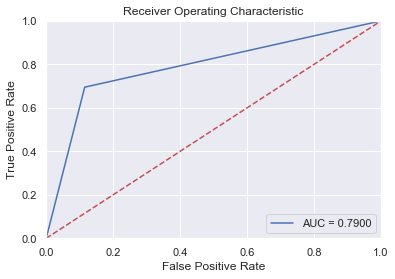

In [22]:
# Plot the ROC curve chart 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


The decision tree showed lower 'sensitivity' in classifying customers who will use the service more than 12 months even after down sampling. 

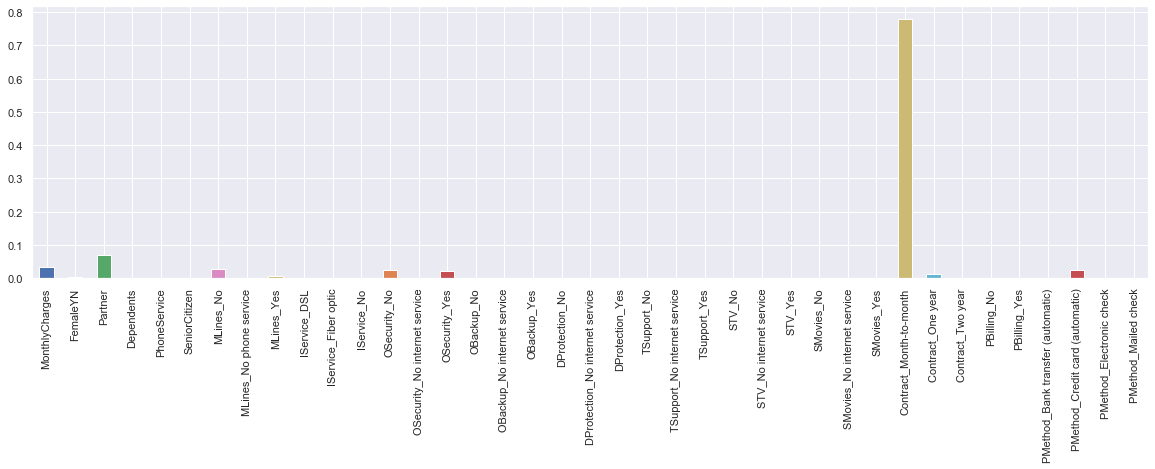

In [23]:
plt.figure(figsize=(20,5))
weights = pd.Series(dt_model.feature_importances_, index=df_impute.columns)
weights.plot(kind='bar')